# 5.12 稠密连接网络（DenseNet）
ResNet中的跨层连接设计引申出了数个后续工作。本节我们介绍其中的一个：稠密连接网络（DenseNet）。 它与ResNet的主要区别如图5.10所示。

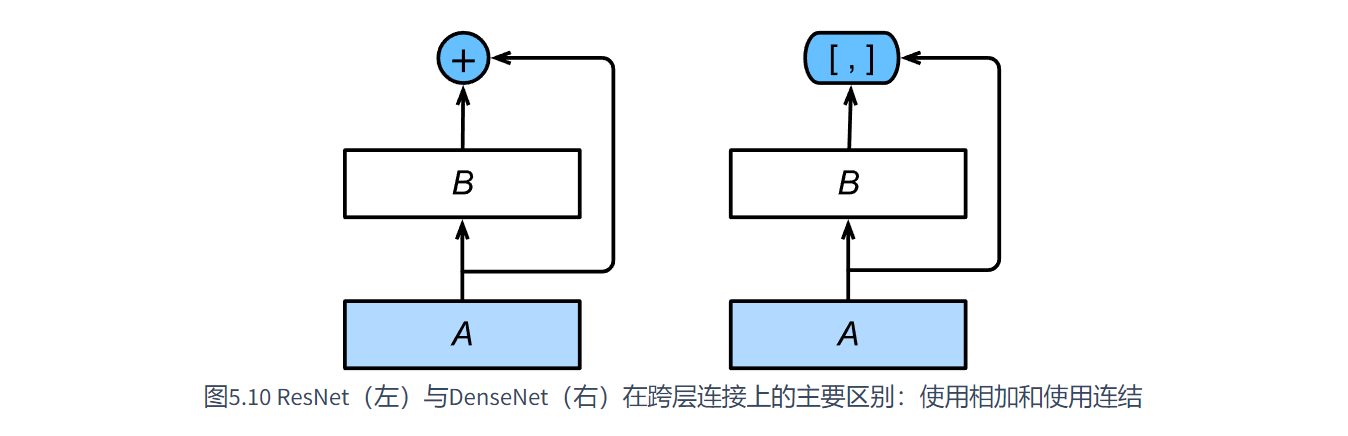

图5.10中将部分前后相邻的运算抽象为模块$A$和模块$B$。与ResNet的主要区别在于，DenseNet里模块$B$的输出不是像ResNet那样和模块$A$的输出相加，而是在通道维上连结。这样模块$A$的输出可以直接传入模块$B$后面的层。在这个设计里，模块$A$直接跟模块$B$后面的所有层连接在了一起。这也是它被称为“稠密连接”的原因。

DenseNet的主要构建模块是稠密块（dense block）和过渡层（transition layer）。前者定义了输入和输出是如何连结的，后者则用来控制通道数，使之不过大。

## 5.12.1 稠密块
DenseNet使用了ResNet改良版的“批量归一化、激活和卷积”结构，我们首先在`conv_block`函数里实现这个结构。

In [1]:
import time
import torch
from torch import nn, optim
import torch.nn.functional as F

import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def conv_block(in_channels, out_channels):
    blk = nn.Sequential(nn.BatchNorm2d(in_channels),
                        nn.ReLU(),
                        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    
    return blk

稠密块由多个`conv_block`组成，每块使用相同的输出通道数。但在前向计算时，我们将每块的输入和输出在通道维上连结。

In [2]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, in_channels, out_channels):
        super(DenseBlock, self).__init__()
        net = []
        for i in range(num_convs):
            in_c = in_channels + i * out_channels
            net.append(conv_block(in_c, out_channels))
        self.net = nn.ModuleList(net)
        self.out_channels = in_channels + num_convs * out_channels  # 计算输出通道数
        
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            X = torch.cat((X, Y), dim=1)  # 在通道维上将输入和输出连结
        return X

在下面的例子中，我们定义一个有2个输出通道数为10的卷积块。使用通道数为3的输入时，我们会得到通道数为$3+2×10=23$的输出。卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称为增长率（growth rate）。

In [3]:
blk = DenseBlock(2, 3, 10)
X = torch.rand(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

## 5.12.2 过渡层
由于每个稠密块都会带来通道数的增加，使用过多则会带来过于复杂的模型。过渡层用来控制模型复杂度。它通过$1×1$卷积层来减小通道数，并使用步幅为2的平均池化层减半高和宽，从而进一步降低模型复杂度。

In [5]:
def transition_block(in_channels, out_channels):
    blk = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.AvgPool2d(kernel_size=2, stride=2)
    )
    
    return blk

对上一个例子中稠密块的输出使用通道数为10的过渡层。此时输出的通道数减为10，高和宽均减半。

In [6]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

## 5.12.3 DenseNet模型
我们来构造DenseNet模型。DenseNet首先使用同ResNet一样的单卷积层和最大池化层。

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

类似于ResNet接下来使用的4个残差块，DenseNet使用的是4个稠密块。同ResNet一样，我们可以设置每个稠密块使用多少个卷积层。这里我们设成4，从而与上一节的ResNet-18保持一致。稠密块里的卷积层通道数（即增长率）设为32，所以每个稠密块将增加128个通道。

ResNet里通过步幅为2的残差块在每个模块之间减小高和宽。这里我们则使用过渡层来减半高和宽，并减半通道数。

In [8]:
num_channels, growth_rate = 64, 32  # num_channels为当前的通道数
num_convs_in_dense_blocks = [4, 4, 4, 4]

for i, num_convs in enumerate(num_convs_in_dense_blocks):
    DB = DenseBlock(num_convs, num_channels, growth_rate)
    net.add_module("DenseBlock_%d" % i, DB)
    # 上一个稠密块的输出通道数
    num_channels = DB.out_channels
    # 在稠密块之间加入通道数减半的过渡层
    if i != len(num_convs_in_dense_blocks) - 1:
        net.add_module("transition_block_%d" % i, transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

同ResNet一样，最后接上全局池化层和全连接层来输出。

In [9]:
net.add_module("BN", nn.BatchNorm2d(num_channels))
net.add_module("relu", nn.ReLU())
net.add_module("global_avg_pool", d2l.GlobalAvgPool2d()) # GlobalAvgPool2d的输出: (Batch, num_channels, 1, 1)
net.add_module("fc", nn.Sequential(d2l.FlattenLayer(), nn.Linear(num_channels, 10))) 

In [14]:
net

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (DenseBlock_0): DenseBlock(
    (net): ModuleList(
      (0): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Sequential(
        (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (3)

我们尝试打印每个子模块的输出维度确保网络无误：

In [11]:
X = torch.rand((1, 1, 96, 96))
for name, layer in net.named_children():
    X = layer(X)
    print(name, 'output shape:\t', X.shape)

0 output shape:	 torch.Size([1, 64, 48, 48])
1 output shape:	 torch.Size([1, 64, 48, 48])
2 output shape:	 torch.Size([1, 64, 48, 48])
3 output shape:	 torch.Size([1, 64, 24, 24])
DenseBlock_0 output shape:	 torch.Size([1, 192, 24, 24])
transition_block_0 output shape:	 torch.Size([1, 96, 12, 12])
DenseBlock_1 output shape:	 torch.Size([1, 224, 12, 12])
transition_block_1 output shape:	 torch.Size([1, 112, 6, 6])
DenseBlock_2 output shape:	 torch.Size([1, 240, 6, 6])
transition_block_2 output shape:	 torch.Size([1, 120, 3, 3])
DenseBlock_3 output shape:	 torch.Size([1, 248, 3, 3])
BN output shape:	 torch.Size([1, 248, 3, 3])
relu output shape:	 torch.Size([1, 248, 3, 3])
global_avg_pool output shape:	 torch.Size([1, 248, 1, 1])
fc output shape:	 torch.Size([1, 10])


## 5.12.4 获取数据并训练模型
由于这里使用了比较深的网络，本节里我们将输入高和宽从224降到96来简化计算。

In [13]:
# batch_size = 256
# # 如出现“out of memory”的报错信息，可减小batch_size或resize
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

# lr, num_epochs = 0.001, 5
# optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda  
epoch 1, loss 0.4432, train acc 0.843, test acc 0.871, time 84.0 sec  
epoch 2, loss 0.2638, train acc 0.902, test acc 0.901, time 84.0 sec  
epoch 3, loss 0.2271, train acc 0.916, test acc 0.904, time 84.1 sec  
epoch 4, loss 0.2063, train acc 0.923, test acc 0.878, time 84.2 sec  
epoch 5, loss 0.1884, train acc 0.931, test acc 0.909, time 84.4 sec

# 小结
* 在跨层连接上，不同于ResNet中将输入与输出相加，DenseNet在通道维上连结输入与输出。
* DenseNet的主要构建模块是稠密块和过渡层。